# **線性迴歸的梯度下降法 (Gradient Descent for Linear Regression)**

<br>

## **目標**
在本實驗中，你將會：
- 使用梯度下降法自動化優化 $w$ 和 $b$ 的過程。

<br>

## **工具**
在本實驗中，我們將使用：
- NumPy，一個用於科學計算的流行庫
- Matplotlib，一個用於繪製數據的流行庫
- 本地目錄中 lab_utils.py 文件中的繪圖例程

In [1]:
import sys, os
import math, copy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#region 匯入相關模組
def find_repo_root(marker="README.md"):
    cur = Path.cwd()
    while cur != cur.parent:  # 防止無限迴圈，到達檔案系統根目錄就停
        if (cur / marker).exists():
            return cur
        cur = cur.parent
    return None


def import_data_from_github():
    import urllib.request, shutil
    
    def isRunningInColab() -> bool:
        return "google.colab" in sys.modules

    def isRunningInJupyterLab() -> bool:
        try:
            import jupyterlab
            return True
        except ImportError:
            return False
        
    def detect_env():
        from IPython import get_ipython
        if isRunningInColab():
            return "Colab"
        elif isRunningInJupyterLab():
            return "JupyterLab"
        elif "notebook" in str(type(get_ipython())).lower():
            return "Jupyter Notebook"
        else:
            return "Unknown"
        
    def get_utils_dir(env): 
        if env == "Colab": 
            if "/content" not in sys.path:
                sys.path.insert(0, "/content")
            return "/content/utils"
        else:
            return Path.cwd() / "utils"

    env = detect_env()
    UTILS_DIR = get_utils_dir(env)
    REPO_DIR = "Machine-Learning-Lab"

    #shutil.rmtree(UTILS_DIR, ignore_errors=True)
    os.makedirs(UTILS_DIR, exist_ok=True)

    BASE = f"https://raw.githubusercontent.com/mz038197/{REPO_DIR}/main"
    urllib.request.urlretrieve(f"{BASE}/utils/lab_utils_common.py", f"{UTILS_DIR}/lab_utils_common.py")
    urllib.request.urlretrieve(f"{BASE}/utils/lab_utils_uni.py", f"{UTILS_DIR}/lab_utils_uni.py")
    urllib.request.urlretrieve(f"{BASE}/utils/deeplearning.mplstyle", f"{UTILS_DIR}/deeplearning.mplstyle")

repo_root = find_repo_root()

if repo_root is None:
    import_data_from_github()
    repo_root = Path.cwd()

os.chdir(repo_root)
print(f"✅ 切換工作目錄至 {Path.cwd()}")
sys.path.append(str(repo_root)) if str(repo_root) not in sys.path else None
print(f"✅ 加入到系統路徑")

from utils.lab_utils_uni import plt_house_x, plt_contour_wgrad, plt_divergence, plt_gradients
plt.style.use('utils/deeplearning.mplstyle')
print("✅ 匯入模組及設定繪圖樣式")
#endregion 匯入相關模組

✅ 切換工作目錄至 d:\Work\Python\Machine-Learning-Lab
✅ 加入到系統路徑
✅ 匯入模組及設定繪圖樣式


<br>

## **問題陳述**

讓我們使用與之前相同的兩個數據點 - 一棟1000坪的房子售價為300萬元，一棟2000坪的房子售價為500萬元。

<div align="center">

| 大小 (1000 坪)     | 價格 (萬) |
| ----------------| ------------------------ |
| <center>1.0</center>               | <center>300.0</center>                      |
| <center>2.0</center>              | <center>500.0</center>                      |

</div>

請完成下面程式碼區塊，以建立你的 `x_train` 和 `y_train` 變數。

In [2]:
x_train = np.array([1.0, 2.0])           #(size in 1000 ping)
y_train = np.array([300.0, 500.0])           #(price in 1000s of dollars)

<br>

## **計算成本**

這是在上一個實驗中開發的。我們在這裡將再次需要它。

請再次定義並完成 `compute_cost(x, y, w, b)` 函式於下方，

In [3]:
def compute_cost(x, y, w, b): 

    m = x.shape[0] 
    cost = 0 
    
    for i in range(m): 
        f_wb = w * x[i] + b   
        cost += (f_wb - y[i]) ** 2  

    total_cost = (1 / (2 * m)) * cost  

    return total_cost

<br>

## **梯度下降摘要 (Gradient descent summary)**
到目前為止，在本課程中，你已經開發了一個線性模型，用於預測 $f_{w,b}(x^{(i)})$：
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{1}$$
在線性回歸中，你通過最小化我們的預測 $f_{w,b}(x^{(i)})$ 與實際數據 $y^{(i)}$ 之間的誤差來擬合參數 $w$、$b$。這個度量稱為 $成本$，$J(w,b)$。在訓練中，你計算所有訓練樣本 $x^{(i)},y^{(i)}$ 的成本

$$
\begin{equation}
J(w,b) = \frac{1}{2m} \sum_{i=0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2
\tag{2}
\end{equation}
$$ 

在講座中，*梯度下降法*被描述為：

$$\begin{align*} \text{重複}&\text{ 直到收斂:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
其中，參數 $w$、$b$ 同時更新。  
梯度定義為：
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

這裡的 *同時* 意味著你在更新任何參數之前計算所有參數的導數項。

<br>

## **實現梯度下降**
你將實現單特徵的梯度下降算法。你需要三個函數。
- `compute_gradient` 實現上面的方程式 (4) 和 (5)
- `compute_cost` 實現上面的方程式 (2)（來自上一個實驗的代碼）
- `gradient_descent`，利用 compute_gradient 和 compute_cost

約定：
- 包含偏導數的 Python 變量的命名遵循這種模式，$\frac{\partial J(w,b)}{\partial b}$ 將被命名為 `dj_db`。
- w.r.t 是 With Respect To 的縮寫，如 $J(w,b)$ 關於 $b$ 的偏導數。

<br>

### **計算梯度**
<a name='ex-01'></a>
請定義並完成 `compute_gradient(x, y, w, b)` 來實現上面的方程式 (4) 和 (5) 並返回 $\frac{\partial J(w,b)}{\partial w}$、$\frac{\partial J(w,b)}{\partial b}$。

In [4]:
def compute_gradient(x, y, w, b): 
    """
    計算線性迴歸的梯度

    Args:
      x (ndarray (m,)): 資料輸入，共 m 筆樣本
      y (ndarray (m,)): 目標值（真實標籤）
      w, b (scalar): 模型參數（斜率與截距）

    Returns:
      dj_dw (scalar): 成本函數對 w 的導數項 (∂J/∂w)
      dj_db (scalar): 成本函數對 b 的導數項 (∂J/∂b)
    """
    
    # Number of training examples
    m = x.shape[0]    
    dj_dw = 0
    dj_db = 0
    
    for i in range(m):  
        f_wb = w * x[i] + b 
        dj_dw_i = (f_wb - y[i]) * x[i] 
        dj_db_i = f_wb - y[i] 
        dj_db += dj_db_i
        dj_dw += dj_dw_i 
        
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 
        
    return dj_dw, dj_db

講座描述了梯度下降如何利用成本函數關於某一點參數的偏導數來更新該參數。   
讓我們使用我們的 `compute_gradient` 函數來找出並繪製我們的成本函數相對於其中一個參數 $w_0$ 的一些偏導數。

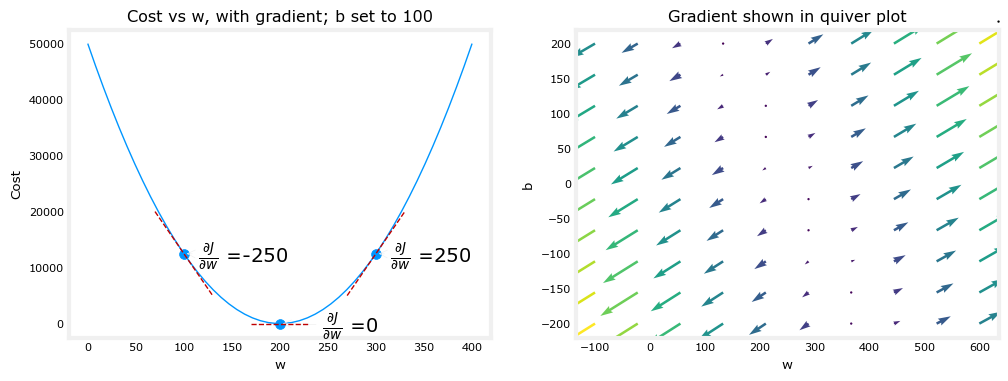

In [5]:
plt_gradients(x_train,y_train, compute_cost, compute_gradient)
plt.show()

上圖左側顯示的是成本函數對 $w$ 的導數項 $\frac{\partial J(w,b)}{\partial w}$，也就是成本曲線相對於 $w$ 的斜率。

上圖的右半部，導數為正值；在左半部，導數為負值。由於成本函數呈現「碗狀」曲線，梯度會自然地指向碗底，也就是成本最低點。
 
在左側圖中，我們固定了 $b=100$。梯度下降會同時利用 $\frac{\partial J(w,b)}{\partial w}$ 與 $\frac{\partial J(w,b)}{\partial b}$ 來更新 $w$ 和  $b$ 參數。

右側的「箭頭圖」則提供了另一個視覺化方式，用箭頭來顯示在每個點上梯度的方向與大小：
* **箭頭長度** 代表梯度的大小。
* **箭頭方向與傾斜角度** 反映了 $\frac{\partial J(w,b)}{\partial w}$ 和 $\frac{\partial J(w,b)}{\partial b}$ 的比率。

請注意，本身指向成本增加的方向。回顧上面的方程式 (3)。縮放後的梯度從 $w$ 或 $b$ 的當前值中 *減去*。這使參數朝著減少成本的方向移動。

<br>

###  **梯度下降**

現在可以來計算梯度了，上面方程式 (3) 中描述的梯度下降可以在下面的 `gradient_descent` 中實作，實作細節已寫在註解中。

接著，你將使用這個函式在訓練資料上尋找 $w$ 和 $b$ 的最佳值。

In [ ]:
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def gradient_descent(
    x, y, w_in, b_in, alpha, num_iters,
    cost_function, gradient_function,
    plot_every=10
):
    """
    執行梯度下降以擬合 w、b。使用學習率 alpha 進行 num_iters 次梯度步來更新 w、b。

    參數 (Args):
    x (ndarray (m,)): 資料，m 筆樣本
    y (ndarray (m,)): 目標值
    w_in, b_in (scalar): 模型參數的初始值
    alpha (float): 學習率
    num_iters (int): 執行梯度下降的迭代次數
    cost_function: 用於計算成本的函式
    gradient_function: 用於計算梯度的函式

    回傳 (Returns):
    w (scalar): 執行梯度下降後更新的參數 w
    b (scalar): 執行梯度下降後更新的參數 b
    J_history (List): 成本值的歷史紀錄
    p_history (list): 參數 [w, b] 的歷史紀錄
    """
    J_history = []
    p_history = []
    b, w = b_in, w_in

    fig, ax = plt.subplots()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Cost")
    ax.set_title("Training Cost (Live)")

    for i in range(num_iters):
        dj_dw, dj_db = gradient_function(x, y, w, b)
        b -= alpha * dj_db
        w -= alpha * dj_dw

        cost = cost_function(x, y, w, b)
        J_history.append(cost)
        p_history.append([w, b])

        if i % plot_every == 0:
            ax.clear()
            ax.plot(J_history)
            ax.set_title("Training Cost (Live)")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Cost")

            ax.text(
                0.02, 0.95,
                f"iter={i}\ncost={cost:.2e}\nw={w:.3e}\nb={b:.3e}",
                transform=ax.transAxes,
                verticalalignment="top"
            )
            plt.show()
            clear_output(wait=True)
            display(fig)

        if i % math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {cost:0.2e} "
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e} "
                  f"w: {w: 0.3e}, b:{b: 0.5e}")

    plt.close(fig)  # 避免最後留一堆圖
    return w, b, J_history, p_history


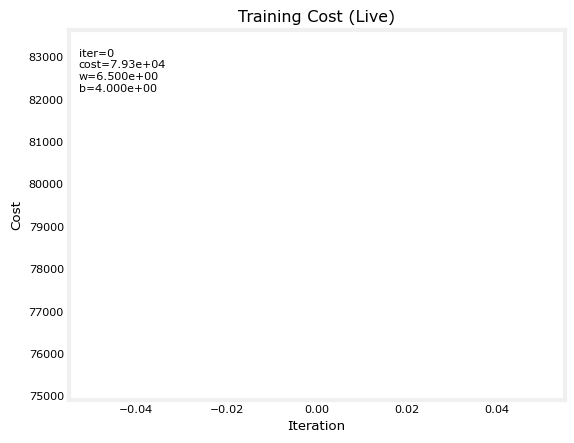

Iteration    0: Cost 7.93e+04 dj_dw: -6.500e+02, dj_db: -4.000e+02 w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00 dj_dw: -3.712e-01, dj_db:  6.007e-01 w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01 dj_dw: -1.789e-01, dj_db:  2.895e-01 w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01 dj_dw: -8.625e-02, dj_db:  1.396e-01 w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02 dj_dw: -4.158e-02, dj_db:  6.727e-02 w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03 dj_dw: -2.004e-02, dj_db:  3.243e-02 w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03 dj_dw: -9.660e-03, dj_db:  1.563e-02 w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04 dj_dw: -4.657e-03, dj_db:  7.535e-03 w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04 dj_dw: -2.245e-03, dj_db:  3.632e-03 w:  2.000e+02, b: 1.00050e+02


KeyboardInterrupt: 

In [7]:
# initialize parameters
w_init = 0
b_init = 0
# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

花點時間注意上面打印的梯度下降過程的一些特點。  

- 成本一開始很大，然後如講座幻燈片中所述迅速下降。

- 導數項 `dj_dw` 和 `dj_db` 也變得更小，一開始迅速，然後變得更慢。如講座圖表所示，當過程接近「碗底」時，由於該點導數值較小，進展變得更慢。

- 儘管學習率 $\alpha$ 保持固定，進展還是會變慢

<br>

### **成本與梯度下降迭代的關係**

繪製「成本（cost）」隨著「迭代次數（iterations）」變化的圖表，是觀察梯度下降學習的好方法。在理想情況下，成本應該隨著每次迭代逐步下降，直到收斂至最低值。

由於在初期階段，成本下降速度通常非常快，因此在繪圖時，會使用兩個不同的縮放比例（scale）來清楚呈現。

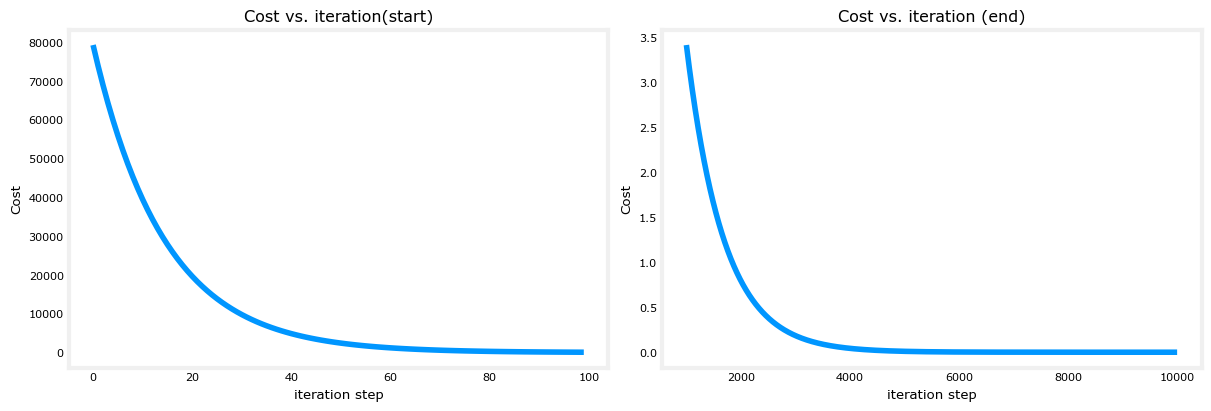

In [8]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()

<br>

### **預測**
現在你已經找到了最佳的參數 $w$ 和 $b$，可以用這個訓練好的模型來預測房價了!

正如預期的那樣：

* 對於訓練集中已有的房屋資料，模型的預測值幾乎與實際價格相同。

* 對於未出現在訓練集的新房屋面積（例如 1200 ping），模型的預測結果也符合預期趨勢，合理地落在資料線上。

In [ ]:
print(f"1000 ping house prediction {w_final*1.0 + b_final:0.1f} Ten Thousand dollars")
print(f"1200 ping house prediction {w_final*1.2 + b_final:0.1f} Ten Thousand dollars")
print(f"2000 ping house prediction {w_final*2.0 + b_final:0.1f} Ten Thousand dollars")

<br>

## **繪圖**

你可以在 成本函數的等高線圖（contour plot） 上，動態地繪製出「成本隨迭代次數變化」的過程，以視覺化呈現 **梯度下降（gradient descent）** 的學習軌跡。

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt_contour_wgrad(x_train, y_train, p_hist, ax)

上面的等高線圖顯示了在不同 $w$ 與 $b$ 組合下的成本還數 $cost(w,b)$。

圖中的「環狀線條」代表不同的成本等高層級，而紅色箭頭則表示 **梯度下降（gradient descent）** 的移動路徑。

以下是一些值得注意的觀察重點：

- 路徑朝著目標穩定（單調）前進。

- 初期步伐較大，後期步伐較小。

如果 **放大觀察**，你會看到梯度下降在接近最低點時的細微動態變化。

* 每一步之間的距離（也就是更新幅度）逐漸縮小。

* 這是因為梯度的大小越來越小，意味著曲面的斜率變得平緩，模型即將收斂。

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
plt_contour_wgrad(x_train, y_train, p_hist, ax, w_range=[180, 220, 0.5], b_range=[80, 120, 0.5],
            contours=[1,5,10,20],resolution=0.5)

<br>

### **增加學習率**

在課堂中，我們討論了方程式（3）中的學習率 $\alpha$ 的適當取值。$\alpha$ 越大，梯度下降收斂到解決方案的速度就越快。但是，如果它太大，梯度下降將發散。上面的範例展示了一個收斂良好的解。

讓我們嘗試增加 $\alpha$ 的值，看看會發生什麼：

In [ ]:
# initialize parameters
w_init = 0
b_init = 0
# set alpha to a large value
iterations = 10
tmp_alpha = 8.0e-1
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)

在上面的情況中，當學習率 $\alpha$ 設得太大時，你會觀察到參數 $w$ 和 $b$ 在正負之間來回震盪，而且其絕對值會隨著每次迭代越來越大!

此外，每次迭代中 $\frac{\partial J(w,b)}{\partial w}$ 的符號都會改變，表示梯度方向持續反轉。這使得成本（cost）不但沒有下降，反而越來越高。

這是非常典型的徵兆，說明:

🚨 學習率過大，演算法無法收斂，正在「發散（diverging）」！

In [ ]:
plt_divergence(p_hist, J_hist,x_train, y_train)
plt.show()

上圖中，左側圖顯示了 $w$ 在梯度下降前幾步中的進展。$w$ 在正負之間振盪，成本迅速增長。梯度下降同時作用於 $w$ 和 $b$，因此需要右側的 3D 圖來獲得完整的畫面。

<br>

## **恭喜！**
在這個實驗中，你學到了以下內容:
- 深入理解單一變數的梯度下降原理。
- 撰寫計算梯度的程式（Compute Gradient）
- 視覺化梯度的意義
- 完成梯度下降演算法
- 利用梯度下降找出最佳參數
- 探討學習率對模型訓練的影響